In [2]:
using Profile
using PProf
using Plots
using Distributions
include("zipf.jl")

mutable struct quant_OGD_integral{T<:Integer}
    ONE::T
    C_UPPER::T
    lazy_update::T
    step_size::T
    d::T
    counter::Dict{T,T}
    uniforms::Dict{T,T}
    dlook::Dict{T,Set{T}}
    cache::Set{T}
    to_evict::Set{T}
end

function Base.show(io::IO, q::quant_OGD_integral)
    println(io, "QuantOGD Parameters:")
    println(io, "-------------------------")
    println(io, "ONE:      ", q.ONE)
    println(io, "Overhead:  ", q.overhead)
    println(io, "Lazy Update: ", q.lazy_update)
    println(io, "Step Size:  ", q.step_size)
    println(io, "counter:      ", q.counter)
    println(io, "dlook:      ", q.dlook)
    println(io, "cache:      ", q.cache)
    println(io, "cache:      ", q.to_evict)
    println(io, "-------------------------")
end

#push and delete is half of profiled time
function step!(q::quant_OGD_integral, i::Int)
    q.d = q.counter[i] > q.uniforms[i] ? q.counter[i] - q.uniforms[i] : 0
    delete!(q.dlook[q.d], i)
    if q.counter[i] > q.lazy_update
        q.counter[i] += min(q.ONE - q.counter[i] + q.lazy_update, q.step_size)
    else
        q.counter[i] = q.lazy_update + q.step_size
    end
    q.d = q.counter[i] > q.uniforms[i] ? q.counter[i] - q.uniforms[i] : 0
    q.dlook[q.d] = push!(get(q.dlook, q.d, Set()), i)
    if q.lazy_update <= q.d
        push!(q.cache, i)
        (i in q.to_evict) && delete!(q.to_evict, i) 
    end
    resize_cache!(q)
end


function resize_cache!(q::quant_OGD_integral)
    if length(q.cache) > q.C_UPPER 
        if !isempty(q.to_evict)
            delete!(q.cache, first(q.to_evict))
            delete!(q.to_evict, first(q.to_evict))
        else
            q.lazy_update += 1
            union!(q.to_evict, get(q.dlook, q.lazy_update, Set()))
        end
        resize_cache!(q)
    end
end


get_fraction(q::quant_OGD_integral, i) = q.counter[i] > q.lazy_update ? (q.counter[i] - q.lazy_update) / q.ONE : 0


# Constructor for quantOGD
function init_quant_OGD_integral(;
    N=100,
    C=10,
    overhead_cache_rate=0.01,
    step_size_real=0.01,
    Typ = UInt32
)
    ONE = Int(ceil(1 / overhead_cache_rate) * div(N, C))
    step_size = floor(step_size_real * ONE)
    C_UPPER = floor(C * (1+overhead_cache_rate))
    d = 0
    lazy_update = 1
    init_count = min(div(ONE * C, N), ONE) + 1
    counter = Dict(i => init_count for i in 1:N)
    uniforms = Dict(i => rand(1:ONE) for i in 1:N)
    dlook = Dict{Typ,Set{Typ}}()
    cache = Set{Typ}()
    to_evict = Set{Typ}()
    # sizehint!(cache, C_UPPER + 1)
    for i in 1:length(counter)
        d = counter[i] > uniforms[i] ? counter[i] - uniforms[i] : 0
        dlook[d] = push!(get(dlook, d, Set{Typ}()), i)
        lazy_update <= d && push!(cache, i)
    end
    q = quant_OGD_integral{Typ}(ONE, C_UPPER, lazy_update, step_size, d, counter, uniforms, dlook, cache, to_evict)
    resize_cache!(q)
    return q
end


function test_init_quant_OGD()
    T = 10^3
    N = 10^2
    C = div(N, 20)
    overhead_cache_rate = 0.01
    step_size_real = sqrt(C * (1 - C / N) / T)
    q = init_quant_OGD_integral(N=N, C=C, overhead_cache_rate=overhead_cache_rate, step_size_real=step_size_real)
    println(q)
end
# test_init_quant_OGD()

function zipf_setup(; T=10^5, N=10^4, overhead_cache_rate=0.03, alpha=1.0, Typ = UInt32)
    C = div(N, 20)
    zipf = ZipfSampler(alpha, N)
    zipf_trace = [sample(zipf) for _ in 1:T]

    step_size_real = sqrt(C * (1 - C / N) / T)
    q = init_quant_OGD_integral(N=N, C=C, overhead_cache_rate=overhead_cache_rate, step_size_real=step_size_real, Typ=Typ)
    return q, zipf_trace
end

function test_time(; T=10^5, N=10^4, overhead_cache_rate=0.03, alpha=1.00, Typ=UInt32)
    q, zipf_trace = zipf_setup(T=T, N=N, overhead_cache_rate=overhead_cache_rate, alpha=alpha, Typ=Typ)
    @time begin
        for j in zipf_trace
            step!(q, j)
        end
    end
    # println(q)
end
# test_time(T = 10^6, N=10^4, overhead_cache_rate =0.01, alpha=0.6, Typ = UInt16)

function profile(; T=10^5, N=10^4, overhead_cache_rate=0.03, alpha=1.00, Typ=UInt32)
    q, zipf_trace = zipf_setup(T=T, N=N, overhead_cache_rate=overhead_cache_rate, alpha=alpha, Typ=Typ)
    Profile.clear()
    @pprof begin
        for j in zipf_trace
            step!(q, j)
        end
    end
    pprof()
end
# profile(T = 10^6, N=10^4, overhead_cache_rate =0.01, alpha=0.6)


function zipf_hitrate_plt(; T=10^5, N=10^4, overhead_cache_rate=0.03, alpha=1.0, window=1000, Typ = Typ)
    q, zipf_trace = zipf_setup(T=T, N=N, overhead_cache_rate=overhead_cache_rate, alpha=alpha, Typ = Typ)
    C = div(N, 20)
    hit = 0.0
    hits = zeros(Float32, length(zipf_trace))
    cachesizes = zeros(Float32, length(zipf_trace))

    for i in 1:length(zipf_trace)
        j = zipf_trace[i]
        hit += (j in q.cache) ? 1 : 0  
        hits[i] = hit
        cachesizes[i] = length(q.cache) 
        step!(q, j)
    end
    ss = div(length(hits), 10^4)  # this for subsampling  
    # Compute the moving maximum over the cachesizes array using the specified window.
    # mov_max = [maximum(cachesizes[max(1, i - window + 1):i]) for i in 1:length(cachesizes)]

    # First plot: moving maximum of the cache sizes.
    p1 = plot(cachesizes[1:ss:end],
        label="Cache Size",
        color=:blue,
        xlabel="time/$ss",
        ylabel="cache size",
        title="subsampled cachesize ")
    hline!(p1, [q.C_UPPER],
        label="C_UPPER",
        color=:red,
        linestyle=:dash)

    # Calculate opt (static optimal hitrate)
    opt = mean(zipf_trace .<= C)
    # Generate the decay curve: cumulative hitrate over time.
    decay_curve = hits ./ (1:length(zipf_trace))

    # Second plot: hitrate decay curve.
    p2 = plot(decay_curve[1:ss:end],
        label="quantOGD",
        color=:green,
        xlabel="time/$ss",
        ylabel="hitrate",
        title="Hitrate on Zipf Trace")
    hline!(p2, [opt],
        label="static_opt_hind",
        color=:red,
        linestyle=:dash)

    # Stack the two plots vertically.
    p = plot(p1, p2, layout=(2, 1), size=(600, 800))
    display(p)
end

zipf_hitrate_plt (generic function with 1 method)

In [4]:
test_time(T = 10^6, N=10^4, overhead_cache_rate =0.01, alpha=0.6, Typ = UInt16)

  0.687128 seconds (2.86 M allocations: 111.757 MiB, 6.17% gc time)


In [ ]:
profile(T = 10^6, N=10^4, overhead_cache_rate =0.01, alpha=0.6)

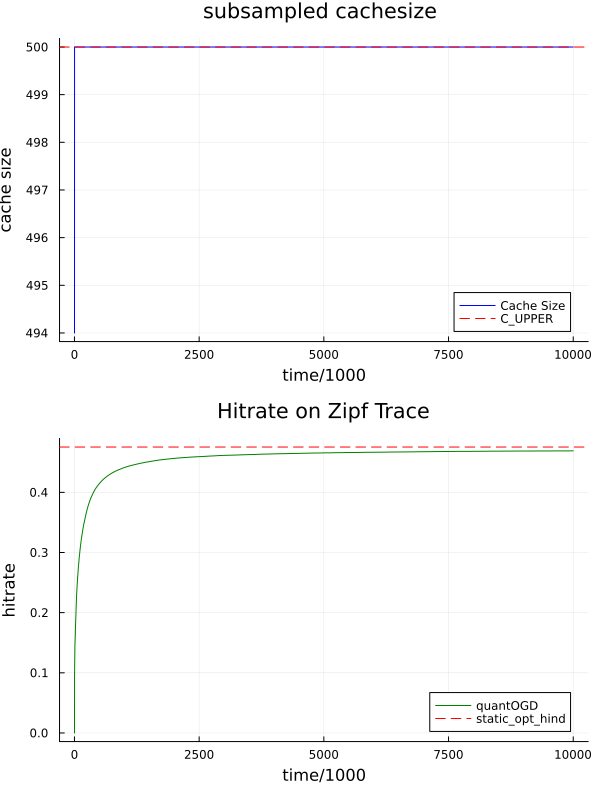

In [6]:
zipf_hitrate_plt(T=10^7, N=10^4, overhead_cache_rate=0.001, alpha=0.8, Typ=UInt32)